In [1]:
suppressPackageStartupMessages({
    source('../libs.R')
    source('../utils.R')    
    source('../Figures/colors.R')    
    # source('../utils_mapping.R')
    source('../utils_plotting.R')
})


# Load

## obj_fibroblasts

In [2]:
dname <- '../../data/cache/obj_fibroblasts/'
fields_load <- c('meta_data', 'effects_nested', 'effects_marginal')
# fields_load <- c('meta_data', 'umap_after', 'umap_before', 'V', 'V_unweighted', 'effects_nested', 'effects_marginal')
obj <- map(fields_load, function(name) {
    readRDS(file.path(dname, paste0(name, '.rds')))
})
names(obj) <- fields_load


obj$meta_data <- obj$meta_data %>% 
    dplyr::mutate(tissue_cluster = case_when(
        tissue_cluster == 'NOTCH3+ perivascular' ~ 'Sublining',
        TRUE ~ tissue_cluster
    ))

masc_res <- readRDS('../../data/cache/confusion_analysis_results.rds')


## adams

In [3]:
adams <- readRDS('../../data/Adams/query.rds')
adams$effects <- readRDS('../../data/Adams/effects.rds')
# adams$masc_res <- readRDS('/data/srlab2/ik936/Roche/data/lung/Adams/masc_res.rds')
adams$frequencies <- readRDS('../../data/cache/adams_ttest_frequencies.rds')

## travaglini

In [4]:
trav <- readRDS('../../data/Travaglini/obj_mesenchymal')

# Travaglini clusters: heatmap

In [5]:
## Markers from paper
markers_list <- map(
    paste0('Cluster ', 25:33), 
    function(sheetname) {
        openxlsx::read.xlsx('../../data/Travaglini/41586_2020_2922_MOESM6_ESM.xlsx', sheetname, startRow = 2) %>% 
            arrange(-avg_logFC) %>% head(20) %>% 
            subset(avg_logFC >= .5) %>%
            dplyr::select(Gene:p_val_adj)
    }
)

names(markers_list) <- c('ASM', 'VSM', 'MyoF', 'FibM', 'AdvF', 'AlvF', 'LipF', 'Peri', 'Meso')
markers <- bind_rows(markers_list, .id = 'Cluster')

## Make markers unique to a cluster 
markers <- data.table(markers)[, .SD[order(-avg_logFC)][1], by = Gene]

## Matrix of betas 
X <- trav$effects %>% 
    subset(feature %in% Reduce(union, markers)) %>% 
    dplyr::select(SCORE=beta, Cluster, feature) %>% 
    tidyr::spread(Cluster, SCORE, fill = 0) %>% 
    tibble::column_to_rownames('feature') %>% 
    as.matrix()

markers <- subset(markers, Gene %in% rownames(X))

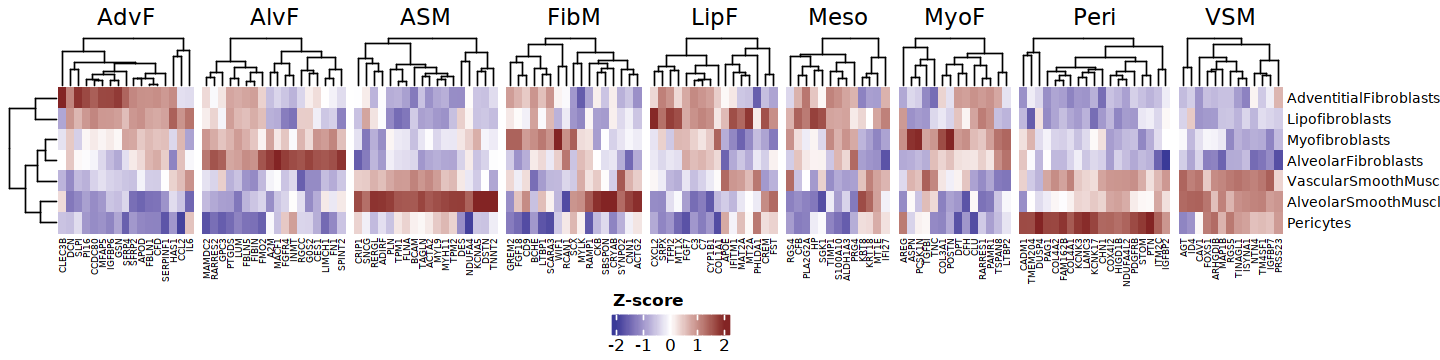

In [6]:
fig.size(3, 12)
ht_opt(RESET = TRUE)
ht_opt("heatmap_column_names_gp" = gpar(fontsize = 5))
ht_opt("heatmap_row_names_gp" = gpar(fontsize = 8))
suppressWarnings({
    h3 <- split(markers$Gene, markers$Cluster) %>% imap(function(.genes, .cluster) {
        ## ComplexHeatmap requires identical columns
        if (.cluster == 'VSM') {
            Heatmap(
                t(X[.genes, ]) %>% scale(),
    #             t(X[.genes, ]),
                show_column_names = TRUE,
                show_heatmap_legend = TRUE,
                name = 'Z-score',
                column_title = .cluster,
                heatmap_legend_param = list(direction = "horizontal"),
                col = colorRamp2(c(-2, 0, 2), c(muted('blue'), "white", muted("red")))
            )
            
        } else {
            Heatmap(
                t(X[.genes, ]) %>% scale(),
    #             t(X[.genes, ]),
    #             show_column_names = FALSE,
                show_heatmap_legend = FALSE,
                column_title = .cluster,
                heatmap_legend_param = list(direction = "horizontal"),
                col = colorRamp2(c(-2, 0, 2), c(muted('blue'), "white", muted("red")))
            )
            
        }
    }) %>% 
        purrr::reduce(`+`)
    
})



h3 <- grid.grabExpr(draw(h3, merge_legend = TRUE, heatmap_legend_side = "bottom"))

# h3 <- grid.grabExpr(draw(h3))
p1 <- wrap_elements(full = h3)
p1

# Trav frequency 

In [7]:
## Travaglini meta data
.m <- fread('../../data/Travaglini/krasnow_hlca_10x_metadata.csv')  %>% 
    subset(compartment == 'Stromal') 

.levels <- c(
    'Pericyte', 'Vascular Smooth Muscle', 'Airway Smooth Muscle', 
    'Alveolar Fibroblast', 'Myofibroblast', 'Adventitial Fibroblast', 
    'Lipofibroblast', 'Fibromyocyte', 'Mesothelial'
) %>% rev()


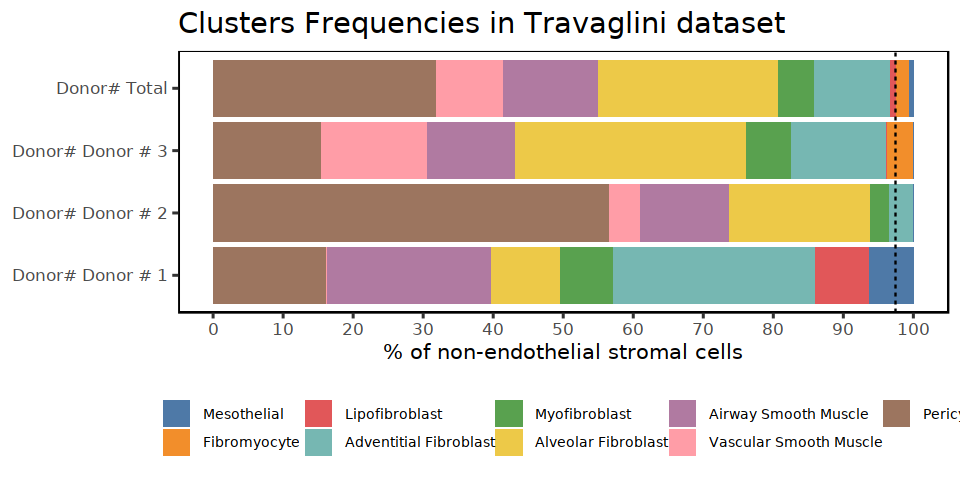

In [8]:
plt_df <- rbind(
    .m %>% 
        with(prop.table(table(free_annotation))) %>% 
        data.table() %>% 
        cbind(patient = 'Total') %>% 
        dplyr::select(patient, free_annotation, N),
    .m %>% 
        with(prop.table(table(free_annotation, patient), 2)) %>% 
        data.table() %>% 
        dplyr::mutate(patient = paste('Donor #', patient)) %>% 
        dplyr::select(patient, free_annotation, N)
) 


p2 <- plt_df %>% 
    dplyr::mutate(free_annotation = factor(free_annotation, .levels)) %>% 
    ggplot(aes(paste0('Donor# ', patient), 100*N, fill = free_annotation)) + 
        geom_bar(stat = 'identity') + 
#         scale_fill_manual(values = palette_global[names(x1)]) + 
        scale_fill_tableau() + 
        coord_flip() + 
        theme(
            legend.position = 'bottom',
            axis.title.y = element_blank(),
            legend.text = element_text(size = 8),
#             legend.title = element_text(size = 10)
            legend.title = element_blank()
        ) + 
        scale_y_continuous(breaks = c(seq(0, 100, by = 10))) + 
        geom_hline(yintercept = 97.5, linetype = 2) + 
        labs(title = 'Clusters Frequencies in Travaglini dataset', y = '% of non-endothelial stromal cells') + 
        NULL

fig.size(4, 8)
p2


# Adams frequency barplot

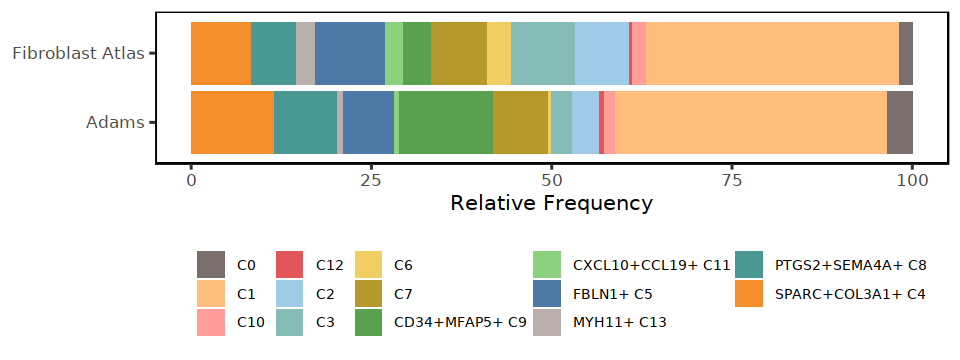

In [9]:
x1 <- subset(obj$meta_data, Tissue == 'Lung') %>% with(prop.table(table(Cluster_name)))
x2 <- adams$meta_data %>% with(prop.table(table(Cluster)))

p4 <- tibble(Adams = as.numeric(x2[names(x1)]), `Fibroblast Atlas` = as.numeric(x1), Cluster = names(x1)) %>% 
    tidyr::gather(key, val, -Cluster) %>% 
    ggplot(aes(key, 100*val, fill = Cluster)) + 
        geom_bar(stat = 'identity') + 
        scale_fill_manual(values = palette_global[names(x1)]) + 
        coord_flip() + 
        theme(
            legend.position = 'bottom',
            axis.title.y = element_blank(),
            legend.text = element_text(size = 8),
#             legend.title = element_text(size = 10)
            legend.title = element_blank()
        ) + 
        labs(y = 'Relative Frequency') + 
        NULL
fig.size(3, 8)
p4

# Adams differential frequency plots

In [10]:
prop_df <- data.table(adams$meta_data)[
    , Ntotal := .N, by = .(Subject_Identity)    
][
    , .N, by = .(Cluster, Subject_Identity, Ntotal)
][
    , prop := N / Ntotal
][] %>% 
    dplyr::select(Cluster, Subject_Identity, prop) %>% 
    tidyr::spread(Subject_Identity, prop, fill = 0) %>% 
    tidyr::gather(Subject_Identity, prop, -Cluster) %>% 
    dplyr::left_join(unique(dplyr::select(adams$meta_data, Subject_Identity, Disease_Identity)))

Joining, by = "Subject_Identity"


Joining, by = "Cluster"


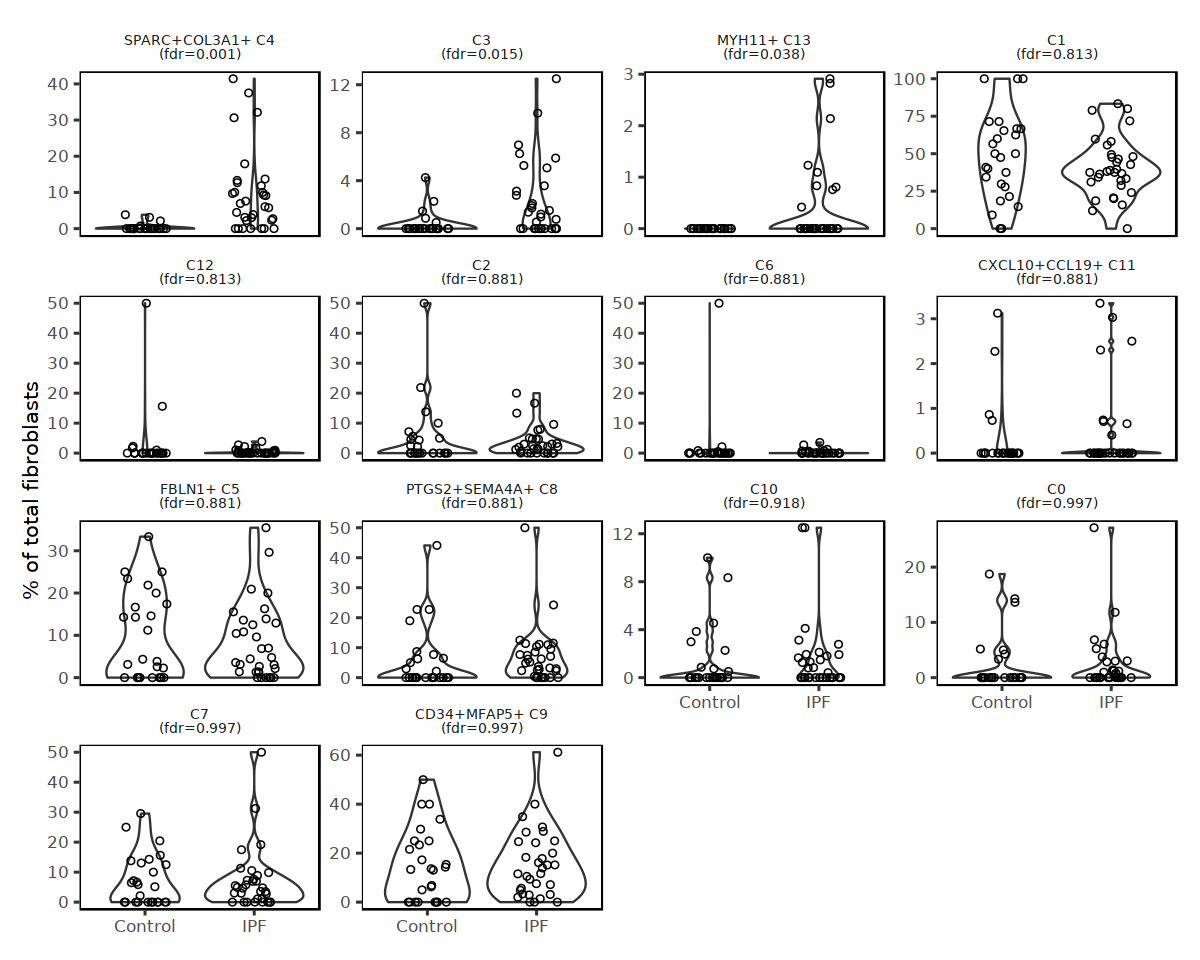

In [11]:
fig.size(8, 10)
plt_df <- prop_df %>% 
#     subset(grepl('C13|C4|C11', Cluster)) %>% 
    left_join(adams$frequencies) %>% 
    dplyr::mutate(LABEL = sprintf('%s\n(fdr=%0.3f)', Cluster, padj)) 
#     dplyr::mutate(Cluster = factor(Cluster, c('SPARC+COL3A1+ C4', 'MYH11+ C13', 'C3', 'CXCL10+CCL19+ C11'))) %>% 
#     dplyr::mutate(LABEL = factor(LABEL, . %>% ) 

plt_levels <- plt_df %>% dplyr::select(LABEL, padj) %>% unique() %>% arrange(padj) %>% with(LABEL)

p5 <- plt_df %>% 
    dplyr::mutate(LABEL = factor(LABEL, plt_levels)) %>% 
    ggplot(aes(Disease_Identity, 100 * prop)) + 
        geom_violin() + 
        geom_jitter(width = .2, height = 0, shape = 21) + 
        facet_wrap(~LABEL, scales = 'free_y', nrow = 4) + 
        labs(y = '% of total fibroblasts') + 
        theme(
            axis.title.x = element_blank(),
            strip.text = element_text(size = 8)
        )


pg <- ggplotGrob(p5)

for(i in which(grepl("^strip", pg$layout$name))){
  pg$grobs[[i]]$layout$clip <- "off"
}

p5 <- wrap_elements(pg)
p5
# p5 <- grid::grid.draw(pg)

# Adams heatmap - marker comparison


In [12]:
beta_thresh <- log(2)
plt_df <- inner_join(
     adams$effects %>% 
        dplyr::select(-contrast),
    obj$effects_nested %>% 
#         left_join(unique(dplyr::select(obj$meta_data, matches('^Cluster')))) %>% 
        subset(Tissue == 'Lung') %>% 
        dplyr::select(-contrast),
    by = c('feature'), 
    suffix = c('_adams', '_roche')
) 

cor_df <- split(plt_df, plt_df$Cluster_adams) %>% imap(function(.SD, .cluster_adams) {
        split(.SD, .SD$Cluster_roche) %>% imap(function(.SE, .cluster_roche) {
            .SE %>% 
                dplyr::mutate(LABEL = case_when(
                    (abs(beta_roche) > beta_thresh & abs(zscore_roche) > 1.96) | 
                    (abs(beta_adams) > beta_thresh & abs(zscore_adams) > 1.96) ~ 'yes', 
                    TRUE ~ 'no'
                )) %>% 
                subset(LABEL == 'yes') %>% 
                with(cor.test(~beta_roche + beta_adams)) %>% 
                broom::tidy() %>% 
                cbind(Cluster_roche = .cluster_roche)
        }) %>% 
            bind_rows() %>% 
            cbind(Cluster_adams = .cluster_adams)
    }) %>% 
    bind_rows()


cormat <- cor_df %>% 
    dplyr::select(estimate, matches('^Cluster')) %>% 
    tidyr::spread(Cluster_roche, estimate) %>% 
    tibble::column_to_rownames('Cluster_adams') 

In [13]:
data.table(cor_df)[, .SD[order(-estimate)][1], by = Cluster_roche] %>% with(quantile(estimate, c(0, 1)))
# %>% with(sd(estimate))
# with(mean(estimate))

0%      100% 
0.3402066 0.8384365

In [14]:
colnames(cormat) <- paste0('C', colnames(cormat))
rownames(cormat) <- paste0('C', rownames(cormat))

In [15]:
.order <- hclust(dist(cormat))$order

Warning message:
“The input is a data frame, convert it to a matrix.”
Loading required namespace: jpeg



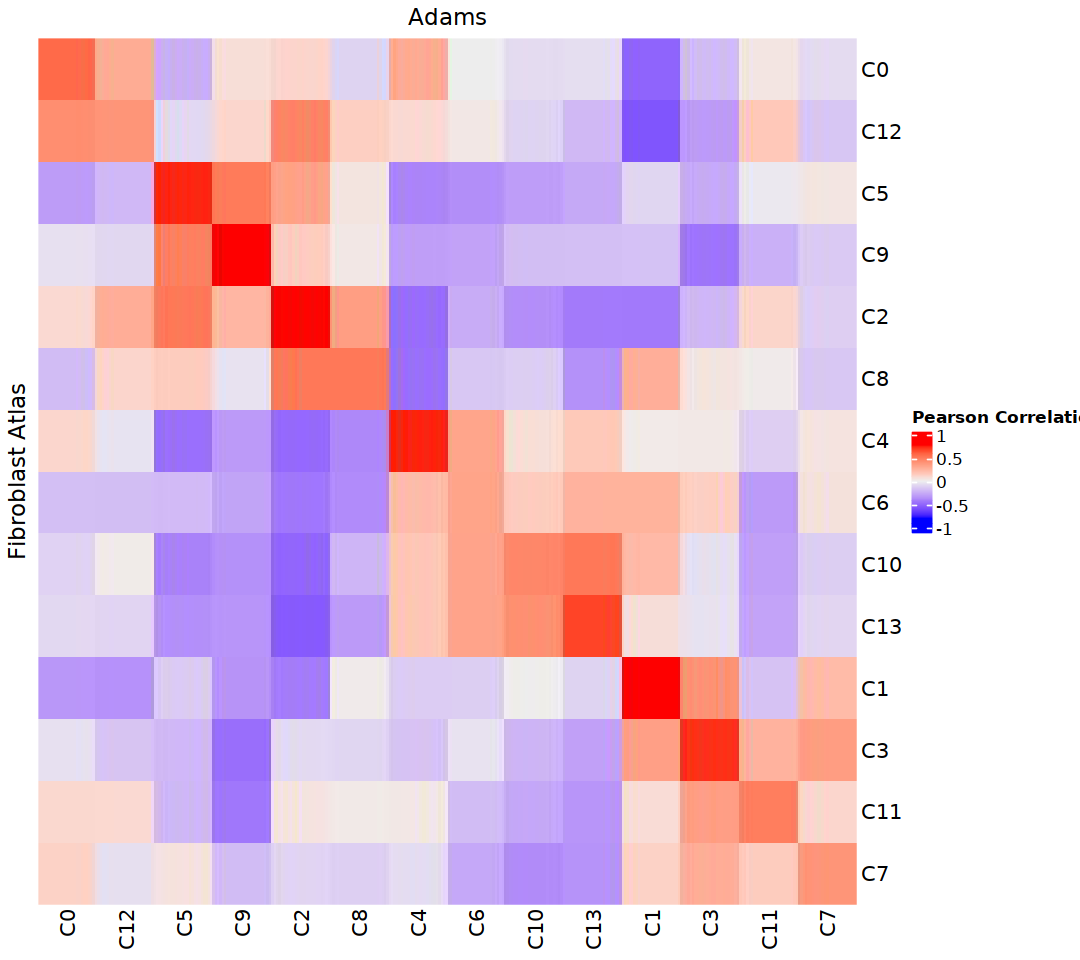

In [16]:
fig.size(8, 9)

ht_opt(RESET = TRUE)
ht_opt("heatmap_column_names_gp" = gpar(fontsize = 12))

h2 <- Heatmap(
    cormat[.order, .order], 
#     cormat, 
    cluster_rows = FALSE, cluster_columns = FALSE,
    row_title = 'Fibroblast Atlas', column_title = 'Adams',
#     col = colorRamp2(c(-1, 0, 1), c(muted('blue'), "white", muted("red"))),
    use_raster = TRUE, raster_device = "CairoJPEG",
    name = 'Pearson Correlation'
)

p6 <- wrap_elements(full = grid.grabExpr(draw(h2)))

p6


# Gut figures

## data

In [17]:
obj <- readRDS('../../data/cache/fibroblast_object_gut.rds')
obj$meta_data <- obj$meta_data %>%
    left_join(
        cbind(
            readRDS('../../data/cache/obj_fibroblasts/umap_after.rds'),
            readRDS('../../data/cache/obj_fibroblasts/meta_data.rds')
        ) %>% 
        dplyr::select(`1`, `2`, CellID, Cluster_name)
    ) 

Joining, by = "CellID"


In [18]:
clusters_nice <- readRDS('../../data/revision2/R1C10_clusters.rds')

In [19]:
gs <- readRDS('../../data/cache/gut_atlas_markers_gs.rds')
markers <- readRDS('../../data/cache/gut_atlas_markers.rds')
markers <- data.table(markers)[feature %in% Reduce(union, gs)][, .SD[order(-auc)][1], by = feature]

X <- wilcoxauc(obj$exprs_norm[markers$feature, ], clusters_nice) %>% 
    dplyr::select(SCORE=auc, group, feature) %>% 
    tidyr::spread(group, SCORE, fill = 0) %>% 
    tibble::column_to_rownames('feature') %>% 
    as.matrix()
    

## panels

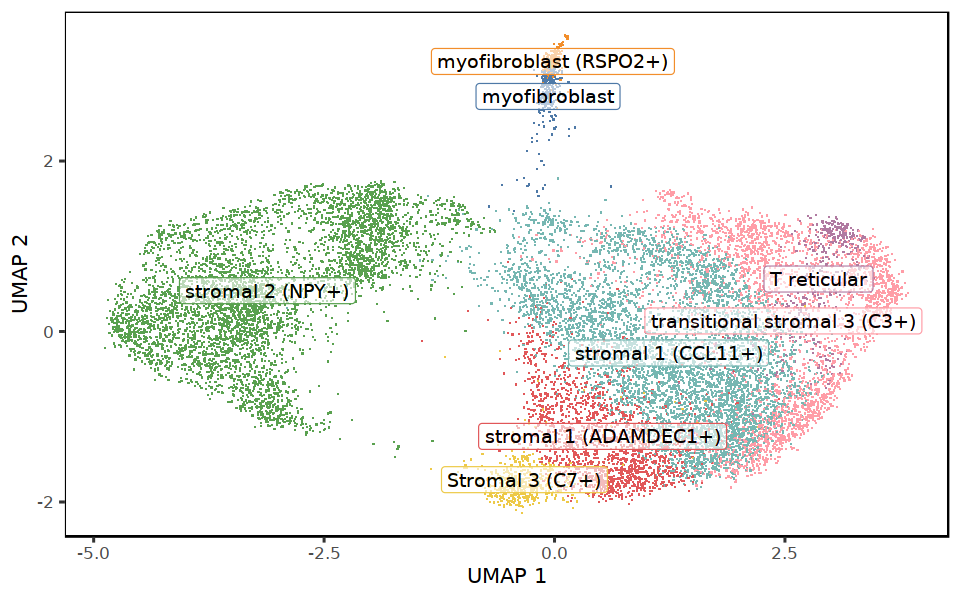

In [20]:
fig.size(5, 8)
p7 <- do_scatter(obj$umap_after, tibble(clusters=clusters_nice), 'clusters', palette_use = tableau_color_pal()(10))
p7

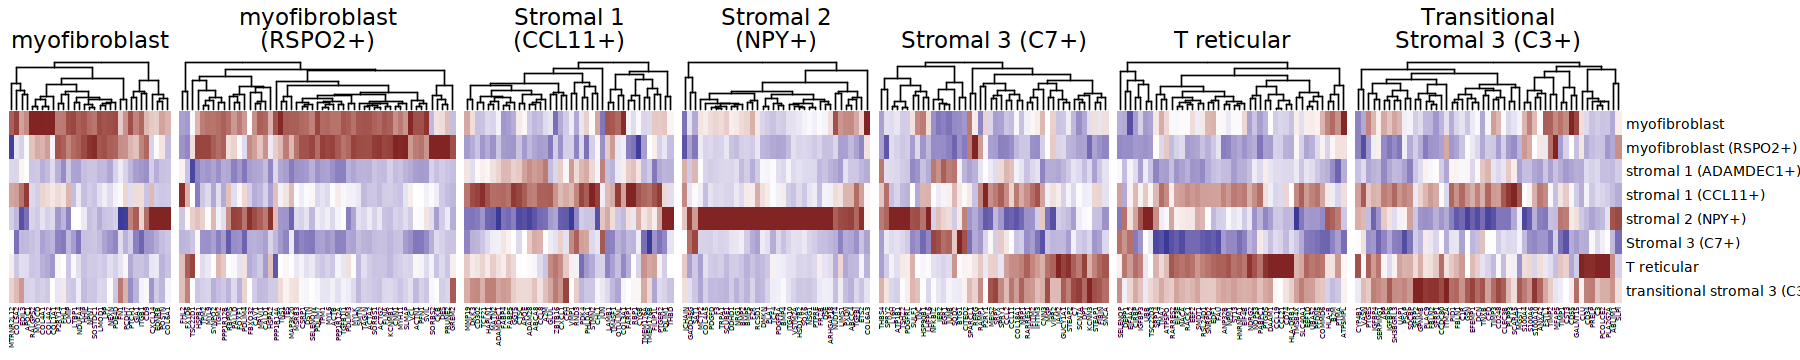

In [21]:
ht_opt(RESET = TRUE)
ht_opt("heatmap_column_names_gp" = gpar(fontsize = 4))
ht_opt("heatmap_row_names_gp" = gpar(fontsize = 8))
suppressWarnings({
    h3 <- split(markers$feature, markers$group) %>% imap(function(.genes, .cluster) {
        ## ComplexHeatmap requires identical columns
        if (.cluster == tail(colnames(X), 1)) {
            Heatmap(
                t(X[.genes, colnames(X)]) %>% scale(),
    #             t(X[.genes, ]),
                cluster_rows = FALSE,
                show_column_names = TRUE,
                show_heatmap_legend = TRUE,
                name = 'Z-score',
                column_title = str_wrap(.cluster, 15),
                heatmap_legend_param = list(direction = "horizontal"),
                col = colorRamp2(c(-2, 0, 2), c(muted('blue'), "white", muted("red")))
            )
            
        } else {
            Heatmap(
                t(X[.genes, colnames(X)]) %>% scale(),
                cluster_rows = FALSE,
    #             t(X[.genes, ]),
    #             show_column_names = FALSE,
                show_heatmap_legend = FALSE,
                column_title = str_wrap(.cluster, 15),
                heatmap_legend_param = list(direction = "horizontal"),
                col = colorRamp2(c(-2, 0, 2), c(muted('blue'), "white", muted("red")))
            )
            
        }
    }) %>% 
        purrr::reduce(`+`)
    
})



h3 <- grid.grabExpr(draw(h3, merge_legend = TRUE, heatmap_legend_side = "bottom"))

fig.size(3, 15)
p8 <- wrap_elements(full = h3)
p8

Joining, by = c("CellID", "Cluster_name")


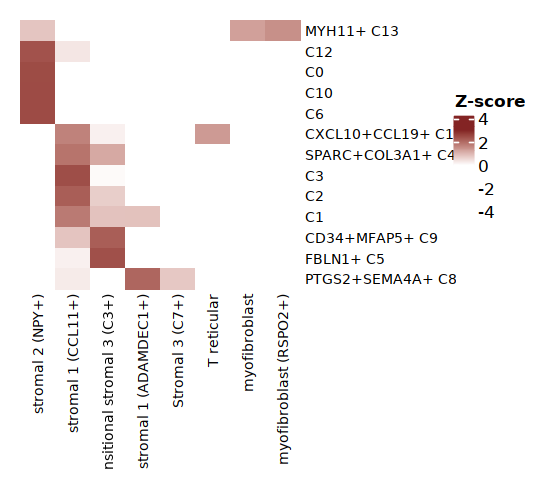

In [22]:
fig.size(4, 4.5)
ht_opt(RESET = TRUE)
ht_opt("heatmap_column_names_gp" = gpar(fontsize = 8))
ht_opt("heatmap_row_names_gp" = gpar(fontsize = 8))

h0 <- obj$meta_data %>% 
    left_join(dplyr::select(readRDS('../../data/cache/obj_fibroblasts/meta_data.rds'), CellID, Cluster_name)) %>% 
    cbind(cluster_atlas = clusters_nice) %>% 
    subset(!Cluster_name %in% c('C7')) %>% 
    with(table(Cluster_name, cluster_atlas)) %>% 
    prop.table(1) %>% 
    t %>% scale %>% t %>% 
    Heatmap(
        col = colorRamp2(c(-3, 0, 3), c('white', "white", muted("red"))),
        show_column_dend = FALSE,
        name = 'Z-score',
        show_row_dend = FALSE      
    )
p9 <- wrap_elements(grid.grabExpr(draw(h0)))
p9

# Panels

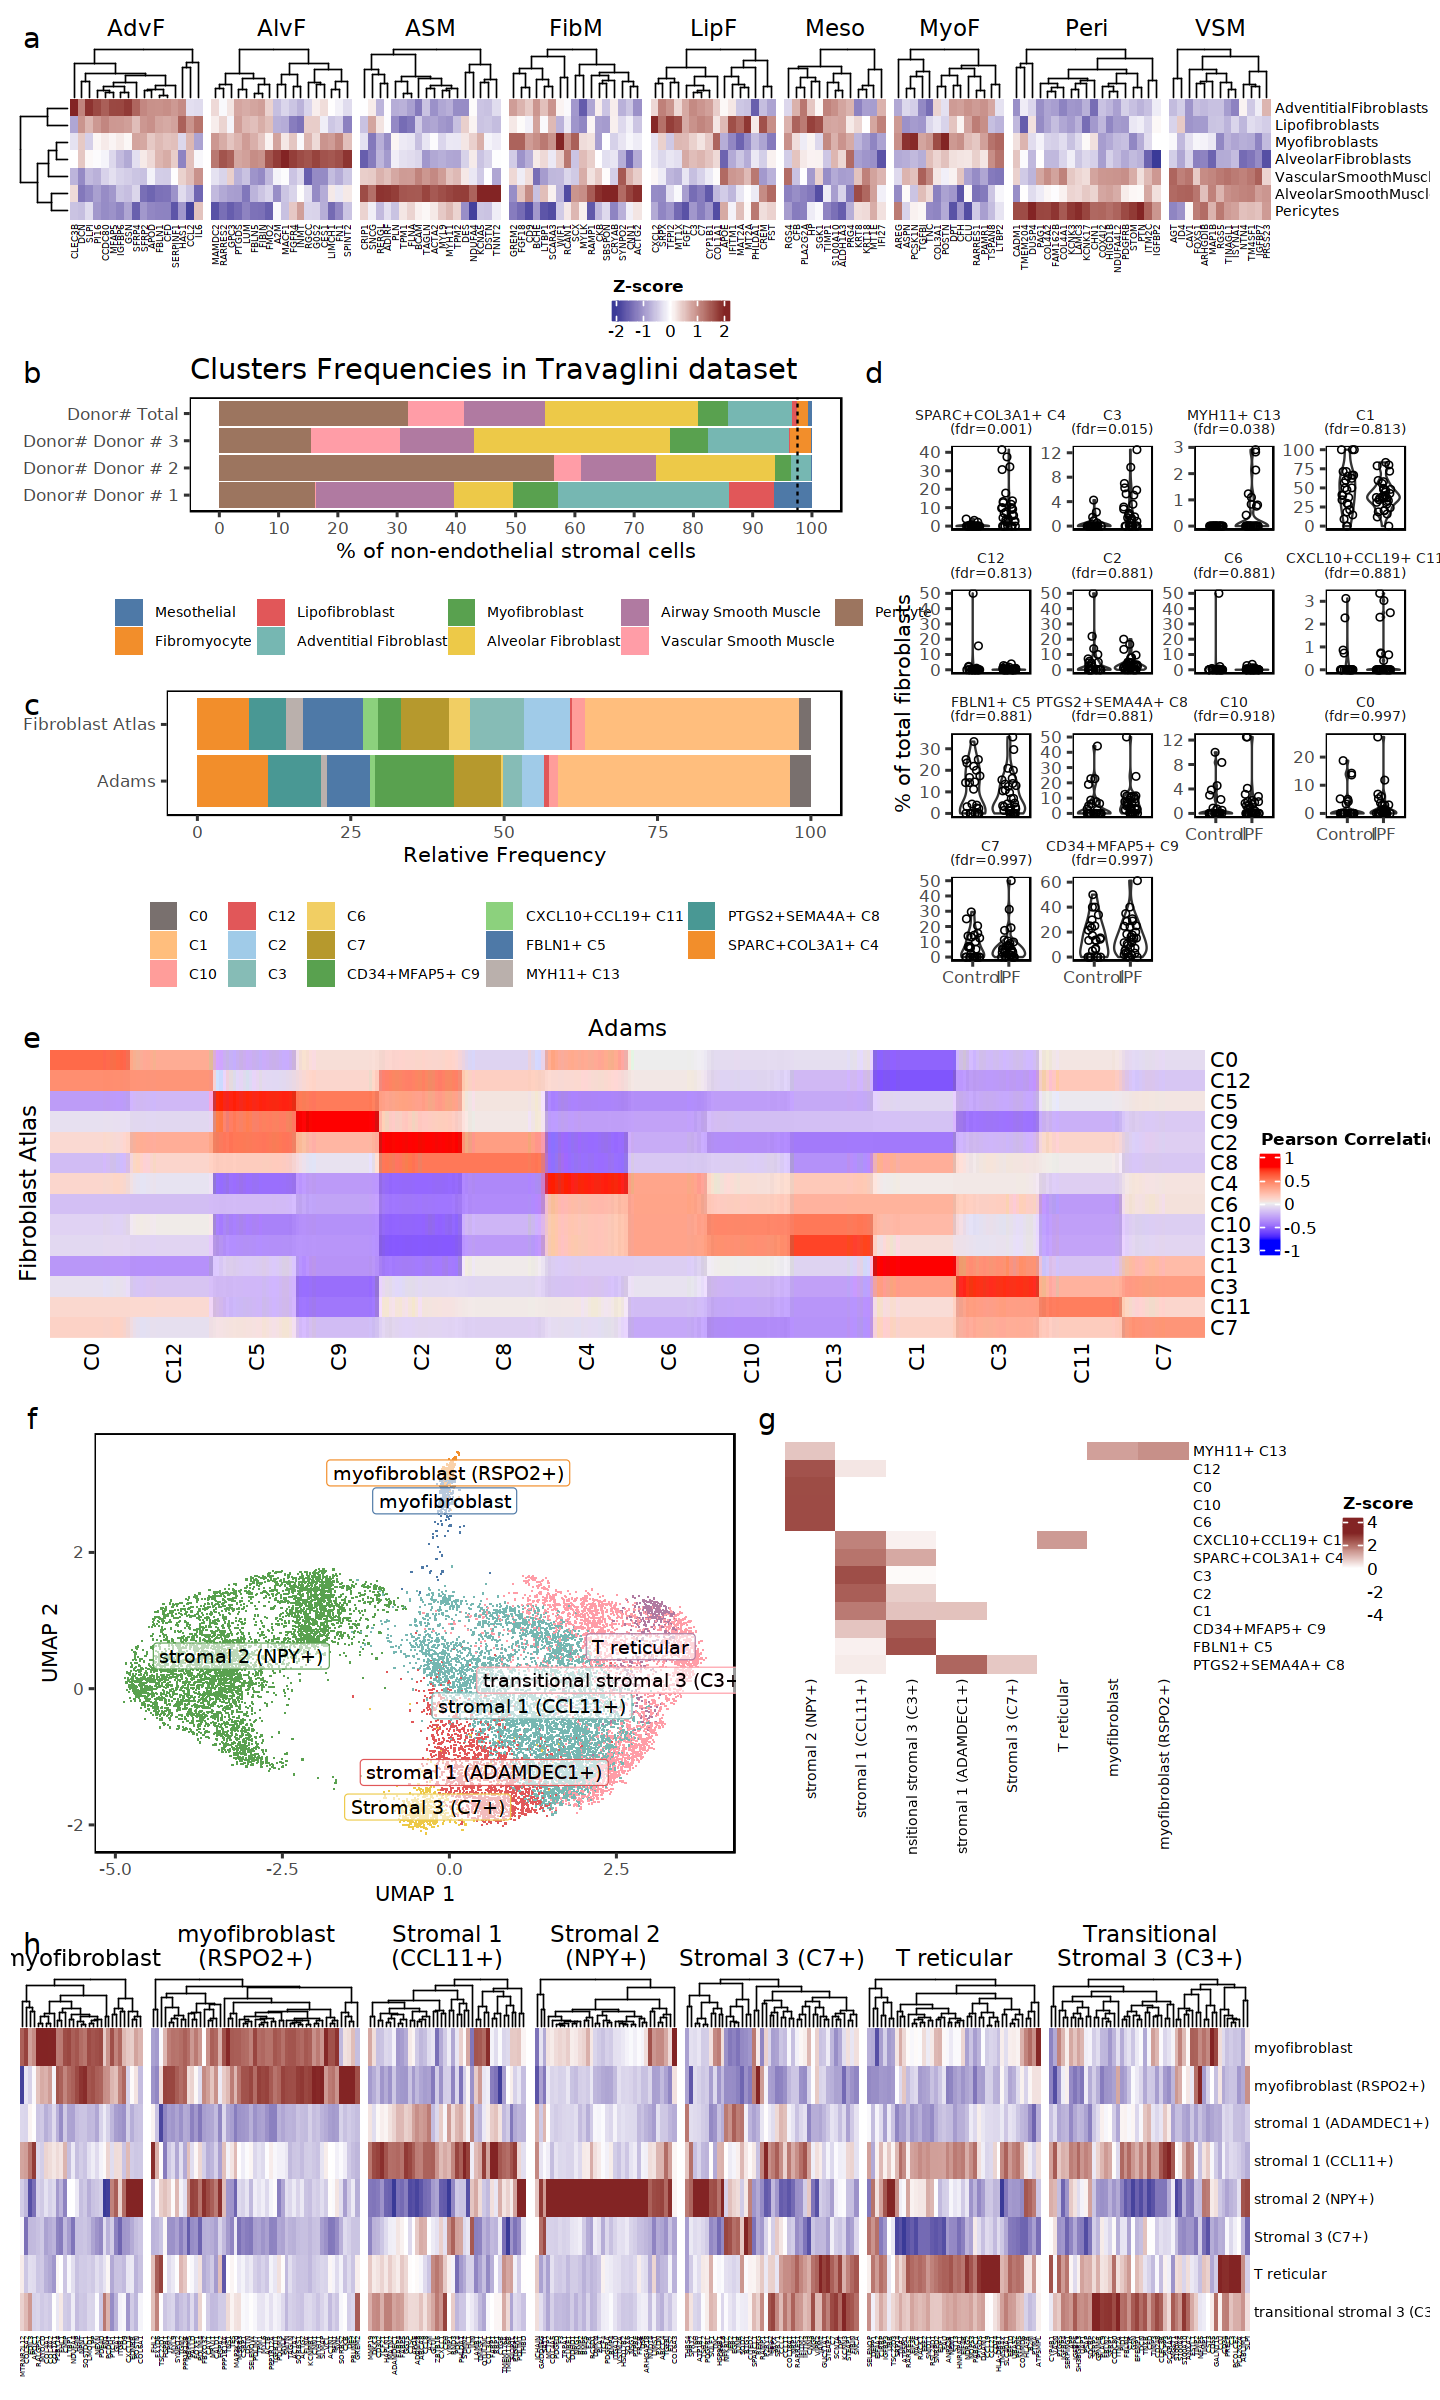

In [23]:
fig.size(20, 12)
fig <- (
    p1  / 
    (
        (
            (
                (wrap_elements(full = p2) /  wrap_elements(full = p4)) | 
                p5
            )  + 
                plot_layout(widths = c(1.4, 1))
            
        )
    ) / 
    (
        p6     
    ) / (
        (p7 | p9) / p8 
    )
) + 
plot_layout(heights = c(.6, 1.3, .7, 2)) + 
plot_annotation(tag_levels = 'a')

fig

In [24]:
ggsave(
    filename = '../../manuscript/figures/SuppFigure8.pdf', 
    plot = fig, 
    units = 'in', device = 'pdf', 
    height = 20, width = 12,
    useDingbats = FALSE
)


ggsave(
    filename = '../../manuscript/figures/SuppFigure8.png', 
    plot = fig, 
    units = 'in', device = 'png', 
    height = 20, width = 12
)
